In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()


0it [00:00, ?it/s]

In [2]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [4]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [5]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [6]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [7]:
dataset_text = 'C:\\Users\\linpa\\OneDrive\\Desktop\\image caption generator\\flickr_8k_caption'
dataset_images = 'C:\\Users\\linpa\\OneDrive\\Desktop\\image caption generator\\flickr8k_dataset'


In [8]:
#preparing the data
filename = dataset_text + "/" + "captions.txt"
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [9]:
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of vocabulary =  8763


In [10]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

 #2048 feature vector
# features = extract_features(dataset_images)
# dump(features, open("features.p","wb"))

In [11]:
# since we already dumped features one time now only opening the downloaded features in reading mode so we dont have to extract 
# features again and again while rerunning the kernel in the notebook  
features = load(open("features.p","rb"))

In [12]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [13]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '
            start' + " ".join(image_caption) + 'end'
            descriptions[image].append(desc)
    return descriptions

In [14]:
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [15]:
filename = dataset_text + "/" + "captions_train.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [16]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary



def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

10400

In [17]:
#We calculate the maximum length of the descriptions. This is important for deciding the model structure parameters. Max_length of description is 32.
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [18]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [19]:
import tensorflow as tf

# Updated data generator to yield correct tuple structure
def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        for key, description_list in descriptions.items():
            # Retrieve photo features
            feature = features[key][0]  # feature should be (2048,)
            
            # Generate input-output pairs from descriptions
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)

            # Convert numpy arrays to tensors and ensure the types are correct
            input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)    # (batch_size, 2048)
            input_sequence = tf.convert_to_tensor(input_sequence, dtype=tf.float32)  # (batch_size, max_length)
            output_word = tf.convert_to_tensor(output_word, dtype=tf.float32)    # (batch_size, vocab_size)

            # Yield the data as a tuple, ensure it is a tuple of tuples
            yield ((input_image, input_sequence), output_word)

# Wrapping the generator using tf.data.Dataset
def get_tf_data_generator(descriptions, features, tokenizer, max_length):
    # Define the output signature for the dataset
    output_signature = (
        (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # input_image feature vector
         tf.TensorSpec(shape=(None, max_length), dtype=tf.float32)),  # input_sequence
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # output_word (categorical word vector)
    )
    
    # Create a tf.data.Dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(descriptions, features, tokenizer, max_length),
        output_signature=output_signature
    )
    
    return dataset

# Ensure the create_sequences function remains the same but properly returns numpy arrays
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()

    for desc in desc_list:
        # Convert description to sequence of integers
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # Split into input-output pairs
        for i in range(1, len(seq)):
            in_seq = seq[:i]
            out_seq = seq[i]
            
            # Pad input sequence to max_length
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # One-hot encode the output word
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            # Store the feature (image), input sequence, and output word
            X1.append(feature)  # Image feature vector (2048,)
            X2.append(in_seq)   # Padded input sequence
            y.append(out_seq)   # One-hot encoded output word
    
    return np.array(X1), np.array(X2), np.array(y)


In [ ]:
# # train our model
# from tensorflow.keras.layers import add
# print('Dataset: ', len(train_imgs))
# print('Descriptions: train=', len(train_descriptions))
# print('Photos: train=', len(train_features))
# print('Vocabulary Size:', vocab_size)
# print('Description Length: ', max_length)

# model = define_model(vocab_size, max_length)
# epochs = 20
# steps = len(train_descriptions)
# # making a directory models to save our models
# import os

# # Check if the directory 'models' exists, if not, create it
# if not os.path.exists("gen_models"):
#     os.mkdir("gen_models")

# for i in range(epochs):
#     # Use the wrapped data generator
#     dataset = get_tf_data_generator(train_descriptions, train_features, tokenizer, max_length)
#     model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save("gen_models/model_" + str(i) + ".h5")

## the upper cell is commented out since every rerunning doesnt require to train the model 

# Now to generate the captions :


In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
def predict_caption(model, image, tokenizer, max_length):
    # Start the caption with the <start> token
    in_text = 'start'
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to ensure correct length
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get the word index with the highest probability
        yhat = np.argmax(yhat)

        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # Stop if the word is not found or None
        if word is None:
            break

        # Append word to the input text
        in_text += " " + word

        # Stop if we reach the <end> tag
        if word == 'end':
            break

    # Remove the <start> and <end> tokens from the final caption
    final_caption = in_text.replace('start', '').replace('end', '').strip()
    return final_caption

In [22]:
filename1 = dataset_text + "/" + "captions_test.txt"
test_imgs = load_photos(filename1)
test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)
test_features = load_features(test_imgs)

In [23]:
test = test_imgs



In [41]:
# from nltk.translate.bleu_score import corpus_bleu

# #now to validate the test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     #get actual caption 
#     captions = descriptions[key]
#     #predict the caption for image 
#     y_pred = predict_caption(model, features[key], tokenizer, max_length)
#     #split into words
#     y_pred = y_pred.split()
#     #append to the list 
#     actual_captions = [caption.split() for caption in captions]
#     actual.append(actual_captions)
#     predicted.append(y_pred)   

# #calculate Bleu score

# print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5, 0.5, 0, 0)))

## visualize the result

In [24]:
from keras.models import load_model
from pickle import load

# Assuming NotEqual is the custom layer used in your model
# Define or import the NotEqual custom layer
from keras.layers import Layer
import tensorflow as tf

class NotEqual(Layer):
    def call(self, inputs):
        return tf.not_equal(inputs[0], inputs[1])

# Load the tokenizer
max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))

# Load the trained model with custom layer support
model = load_model('gen_models/model_9.h5', custom_objects={'NotEqual': NotEqual})

# Now the model should load successfully with the custom layer/operation


In [27]:
from PIL import Image 
import matplotlib.pyplot as plt
import os  # This helps handle paths properly

def generate_caption(image_name):
    # Folder where the images are stored
    image_folder = "flickr8k_dataset/"

    # Use the full image name (with extension) as the key
    image_id = image_name.strip()  # Remove any leading or trailing spaces

    # Construct the full path to the image inside the folder
    image_path = os.path.join(image_folder, image_name)

    # Open the image using the updated path
    image = Image.open(image_path)

    # Check if the full image name exists in the descriptions dictionary
    if image_id in descriptions:
        captions = descriptions[image_id]
        print('----------------Actual----------------')
        print(captions)
    else:
        print(f"Error: No description found for image ID '{image_id}'")
        return

    # Generate the predicted caption using the extracted image features
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('----------------Predicted----------------')
    print(y_pred)

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Optional: Hide axes for a cleaner display
    plt.show()

----------------Actual----------------
['car is in the water', 'car sinking in water', 'land rover is being driven across river', 'land rover makes its way through deep pond', 'an automobile is submerged in water almost to the door handles']
----------------Predicted----------------
rider is pulled at sunsetend in the middle of the waterend belowend in the backgroundend belowend belowend cloudy skyend overheadend behindend in the backgroundend close to itend himend himend himend herend herend


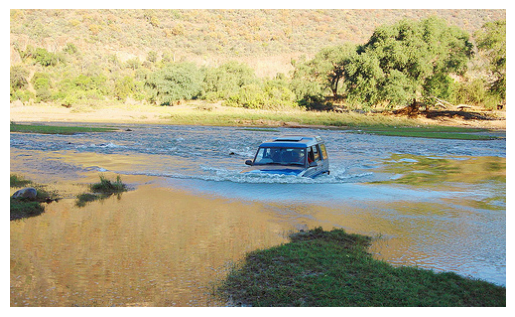

In [28]:
generate_caption("2832076014_ff08c92037.jpg")

In [51]:
import random

# Print 10 random keys from the descriptions dictionary
random_keys = random.sample(list(descriptions.keys()), 10)
print(random_keys)

['1383840121_c092110917.jpg', '491964988_414b556228.jpg', '2433175169_da939372f2.jpg', '2554531876_5d7f193992.jpg', '3530687486_6e6be53602.jpg', '3101796900_59c15e0edc.jpg', '1952896009_cee8147c90.jpg', '244774022_a12c07afdb.jpg', '3621623690_0095e330bc.jpg', '2832076014_ff08c92037.jpg']


# Above one created mistakes so rewriting the code  in another format

In [40]:


# Define a custom layer if necessary
class NotEqual(Layer):
    def call(self, inputs):
        return tf.not_equal(inputs[0], inputs[1])

# Load the tokenizer
max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))

# Load the model with custom layer support
model = load_model('gen_models/model_9.h5', custom_objects={'NotEqual': NotEqual})

# Load the Xception model for feature extraction
xception_model = Xception(include_top=False, pooling="avg")

# Function to extract features from the image
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except Exception as e:
        print(f"ERROR: Couldn't open image! Error: {e}")
        return None
    
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

# Function to map predicted index to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Improved function to generate a caption for the image
def predict_caption(model, photo, tokenizer, max_length):
    in_text = 'start'
    previous_word = None  # To track the previously generated word

    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)

        # Convert the predicted index to a word
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break

        # Avoid repeating the same word consecutively
        if word == previous_word:
            continue

        # Append word to the input sequence
        in_text += ' ' + word
        previous_word = word  # Track the current word as the previous one

        # Stop if the word is the <end> token
        if word == 'end':
            break

    # Clean up the generated sentence by removing <start> and <end> tokens
    final_caption = in_text.replace('start', '').replace('end', '').strip()
    return final_caption

# Main function to generate a caption for a given image
def generate_caption(image_name):
    # Folder where the images are stored
    image_folder = "flickr8k_dataset/"

    # Construct the full path to the image
    image_path = os.path.join(image_folder, image_name)
    
    # Extract features from the image
    photo = extract_features(image_path, xception_model)
    
    if photo is not None:
        # Load and display the image
        img = Image.open(image_path)

        # Generate the predicted caption using the extracted image features
        description = predict_caption(model, photo, tokenizer, max_length)
        
        # Display the results
        print('----------------Predicted----------------')
        print(description)
        
        # Show the image
        plt.imshow(img)
        plt.axis('off')  # Optional: Hide axes for a cleaner display
        plt.show()
    else:
        print("Error: Could not extract features from the image.")




1/1 [==============================] - 1s 1s/step
----------------Predicted----------------
rider is pulled at sunset in the middle of the water below in the background below


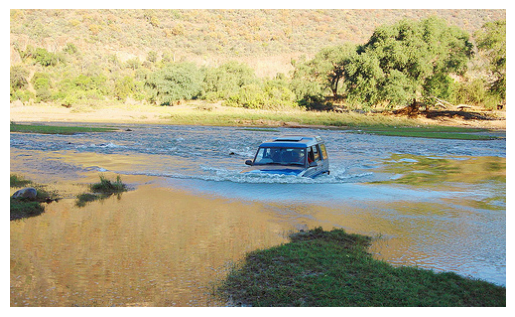

In [39]:
generate_caption("2832076014_ff08c92037.jpg")